In [178]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime

In [179]:
config_data=util.config_load()

In [180]:
df_ben=util.pickle_load(config_data['raw_dataset_path_train_ben'])
df_inp=util.pickle_load(config_data['raw_dataset_path_train_inp'])
df_outp=util.pickle_load(config_data['raw_dataset_path_train_outp'])


**Merging Data**

In [181]:
common_cols=[i for i in df_inp.columns if i in df_outp.columns]

In [182]:
common_cols

['BeneID',
 'ClaimID',
 'Provider',
 'InscClaimAmtReimbursed',
 'AttendingPhysician',
 'OperatingPhysician',
 'OtherPhysician',
 'ClmAdmitDiagnosisCode',
 'DeductibleAmtPaid',
 'ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10',
 'ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'Claim_period',
 'Beneficiary_cost',
 'Count_diag_code',
 'Count_proc_code',
 'Is_admit']

In [125]:
df_inp_outp=pd.merge(left=df_inp, right=df_outp, left_on=common_cols,right_on=common_cols,how='outer')

In [126]:
print(df_inp_outp)

            BeneID    ClaimID  Provider  InscClaimAmtReimbursed  \
0       BENE100000  CLM126832  PRV57172                      50   
1       BENE100000  CLM351838  PRV57172                      70   
2       BENE100001  CLM229075  PRV55158                      70   
3       BENE100001  CLM258631  PRV54966                      70   
4       BENE100001  CLM332544  PRV54890                      90   
...            ...        ...       ...                     ...   
558206   BENE99999  CLM359214  PRV55826                      80   
558207   BENE99999  CLM475422  PRV54670                      80   
558208   BENE99999  CLM591853  PRV57336                      30   
558209   BENE99999  CLM712394  PRV51690                     700   
558210   BENE99999  CLM750563  PRV54670                      50   

       AttendingPhysician OperatingPhysician OtherPhysician  \
0               PHY383401                NaN            NaN   
1               PHY370909                NaN      PHY363377   
2     

In [183]:
df_inp_outp_ben=pd.merge(right=df_inp_outp,left=df_ben,left_on='BeneID',right_on='BeneID',how='right')

In [184]:
df_inp_outp_ben.columns

Index(['BeneID', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'AGE', 'DOD_Flag',
       'TotalIPAnnualAmt', 'TotalOPAnnualAmt', 'ClaimID', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'Cl

In [185]:
len(df_inp_outp_ben)

558211

In [ ]:
df_inp_outp_ben=util.pickle_dump(df_inp_outp_ben, config_data["raw_dataset_path_test_ben"])

In [137]:
df_inp_outp_ben.isna().sum()

BeneID                                  0
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnualReimbursementAmt                0
OPAnnualDeductibleAmt                   0
AGE                               

**Diagnosis code analysis and physician analysis**

Q1. what is the most used diagnosis code in inpatient and outpatient? - Top 10

Q2. what is the most used claim proc code in inpatient and outpatient? - Top 10

Q3. Which diagnosis code contribute to highest reimbursement amount?- Top 10

Q4. Most used diagnosis code group. Verify the variability of reimbursed amount?

Q5. what are the diagnosis code under the most used group code?

Q6. What are the conditions under the most used group code?

Q7. Trend on phycisians with number of claims.

Q8. Providers with highest claims.

Q1: what is the most used diagnosis code in inpatient and outpatient? - Top 10

In [15]:
df_clm_diag_cd = []  # Initialize an empty list

for i in ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
          'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
          'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
          'ClmDiagnosisCode_10']:
    
    df_clm_diag_cd.append(df_inp_outp_ben[i].dropna())  # Append each column to the list
    df_combined=pd.concat(df_clm_diag_cd,axis=0).reset_index(drop=True)
    df_combined=pd.DataFrame(df_combined,columns=['Diagnosiscode'])
    


In [16]:
df_combined

,Diagnosiscode
0,79678
1,71656
2,64881
3,36401
4,2948
...,...
1680711,20380
1680712,28529
1680713,8470
1680714,5733


In [17]:
df_combined

,Diagnosiscode
0,79678
1,71656
2,64881
3,36401
4,2948
...,...
1680711,20380
1680712,28529
1680713,8470
1680714,5733


In [18]:
df_combined_top10 = df_combined.groupby('Diagnosiscode').size().reset_index(name='Count')
df_combined_top10 = df_combined_top10.sort_values(by='Count', ascending=False).head(10)

In [19]:
df_combined_top10.set_index('Diagnosiscode')

,Count
Diagnosiscode,
4019,77056
25000,37356
2724,35763
V5869,24904
4011,23773
42731,20138
V5861,20001
2720,18268
2449,17600


In [20]:
len(df_combined_top10)

10

[]

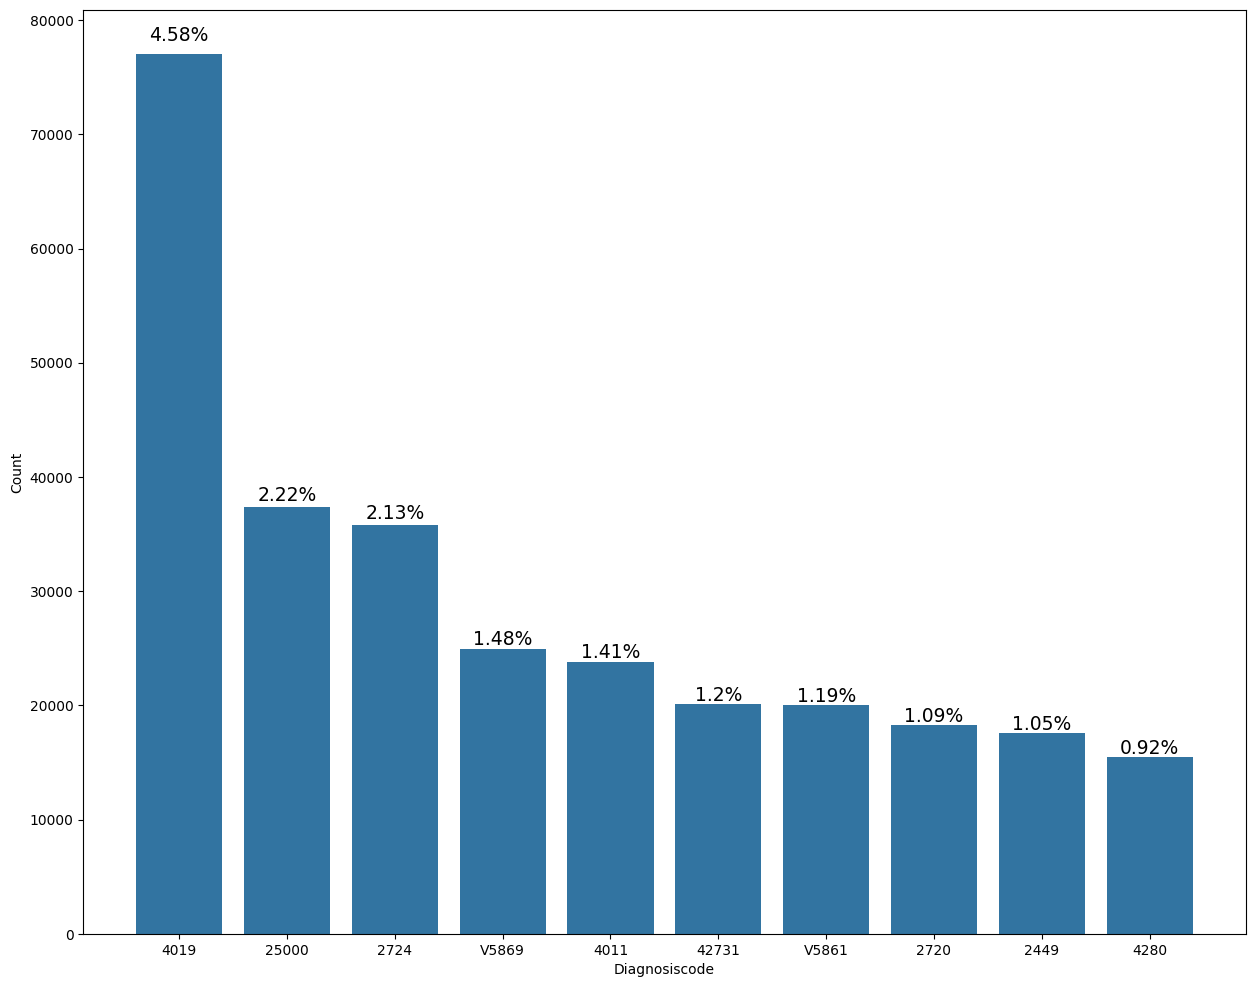

In [21]:
plt.figure(figsize=(15,12))
fig=sns.barplot(data=df_combined_top10,x='Diagnosiscode',y='Count')
for p in fig.patches:
    height=p.get_height()
    width=p.get_width()
    x,y=p.get_xy()
    fig.annotate(f'{str(round((height*100)/len(df_combined),2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
plt.plot()


4019- Unspecified essential hypertension has been used in 4.8% of data

Q3. Which diagnosis code contribute to highest reimbursement amount?- Top 10

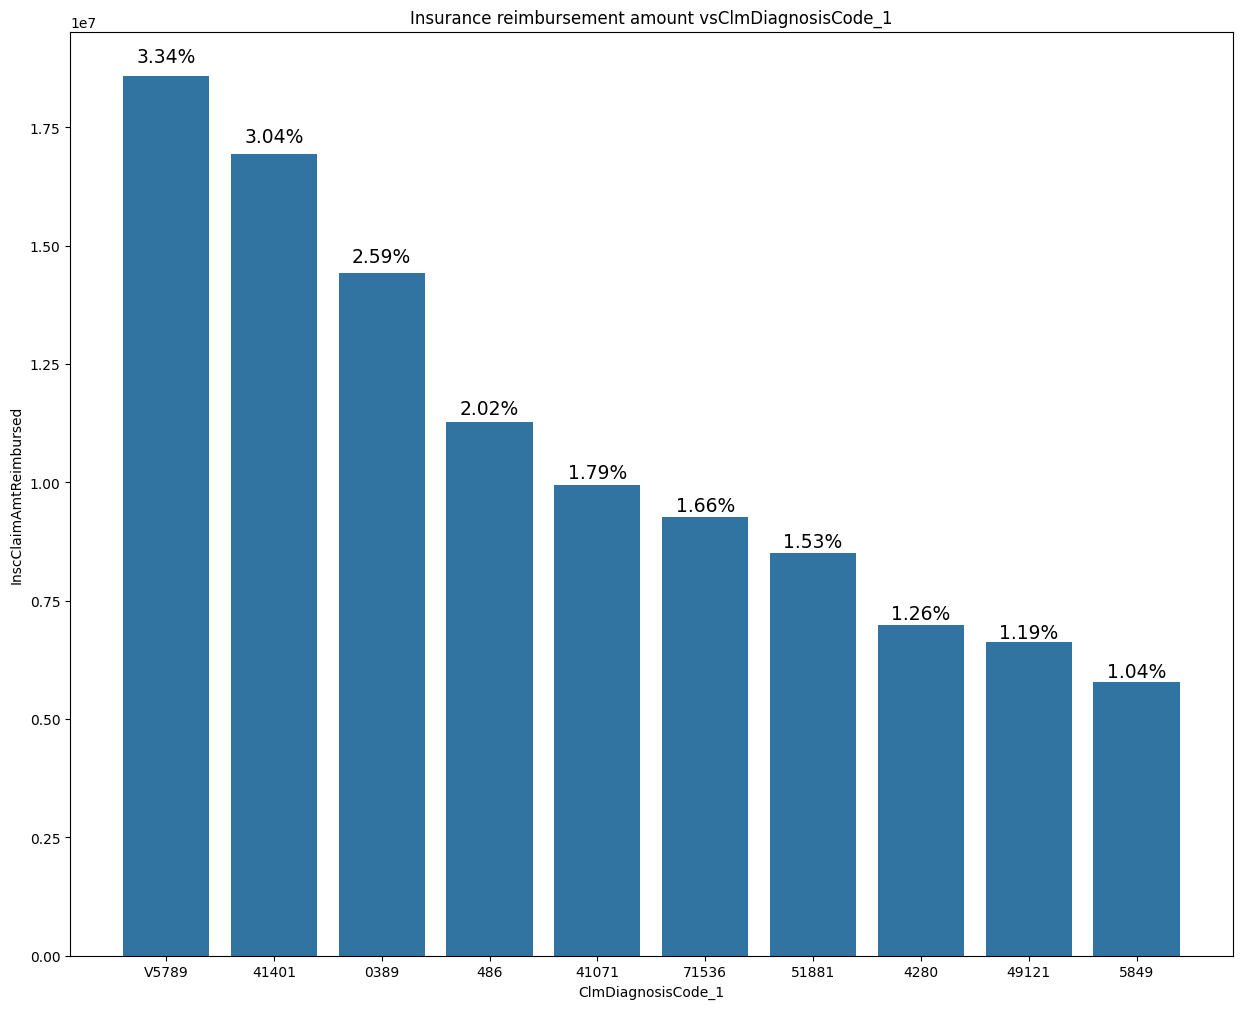

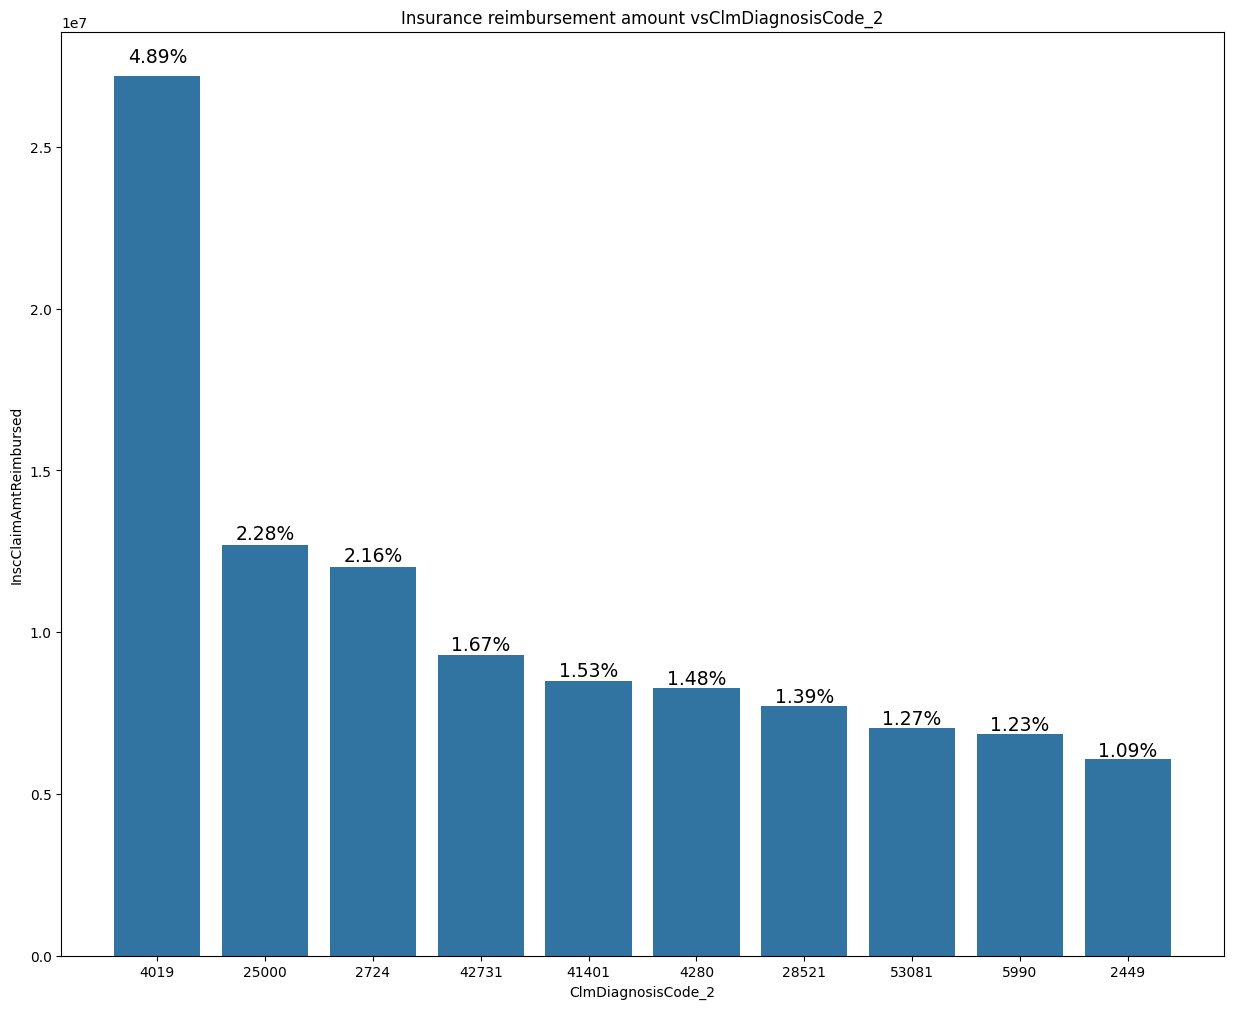

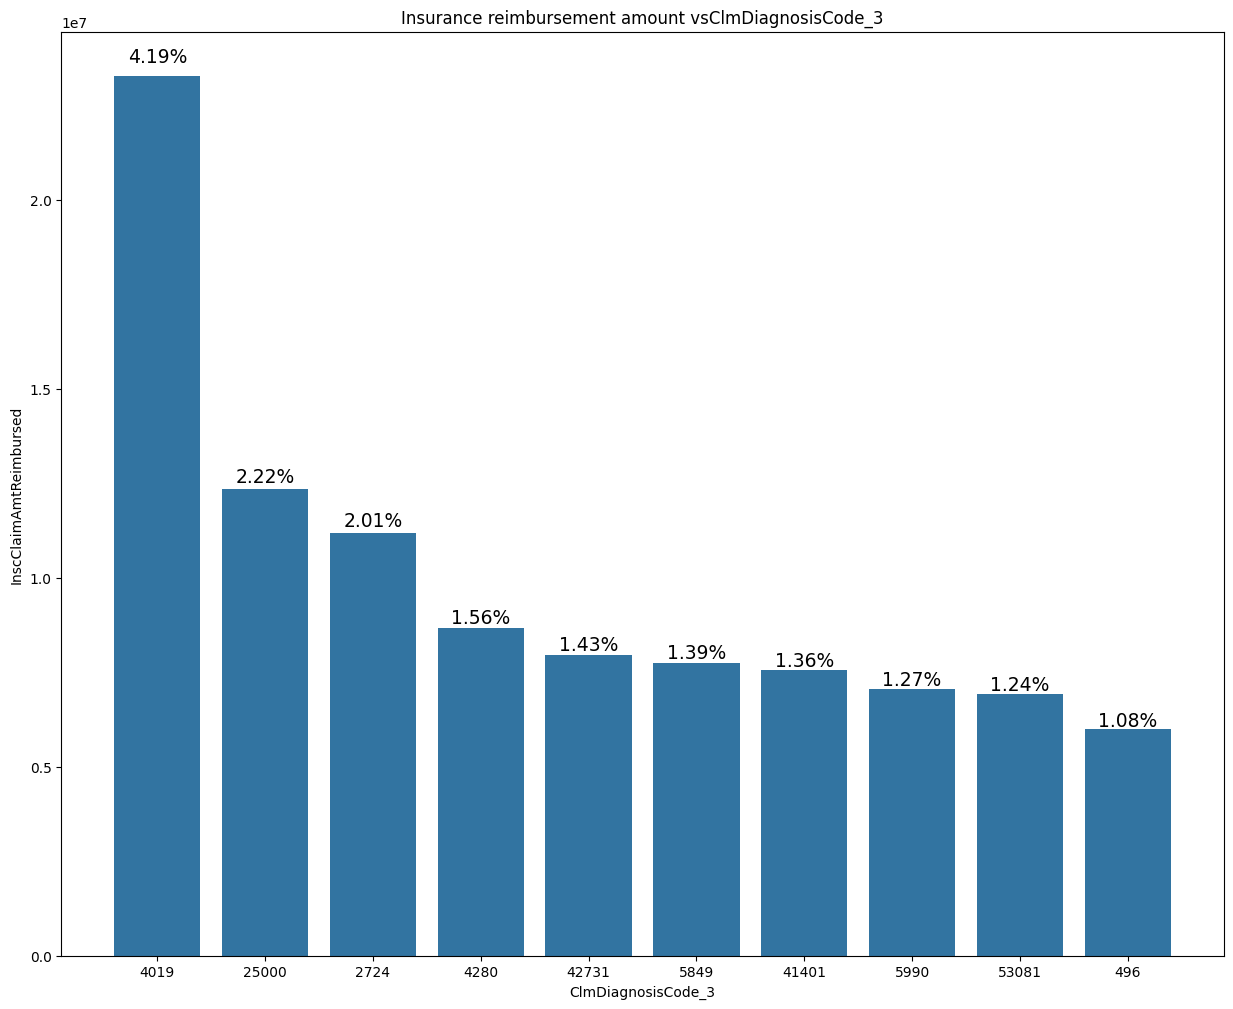

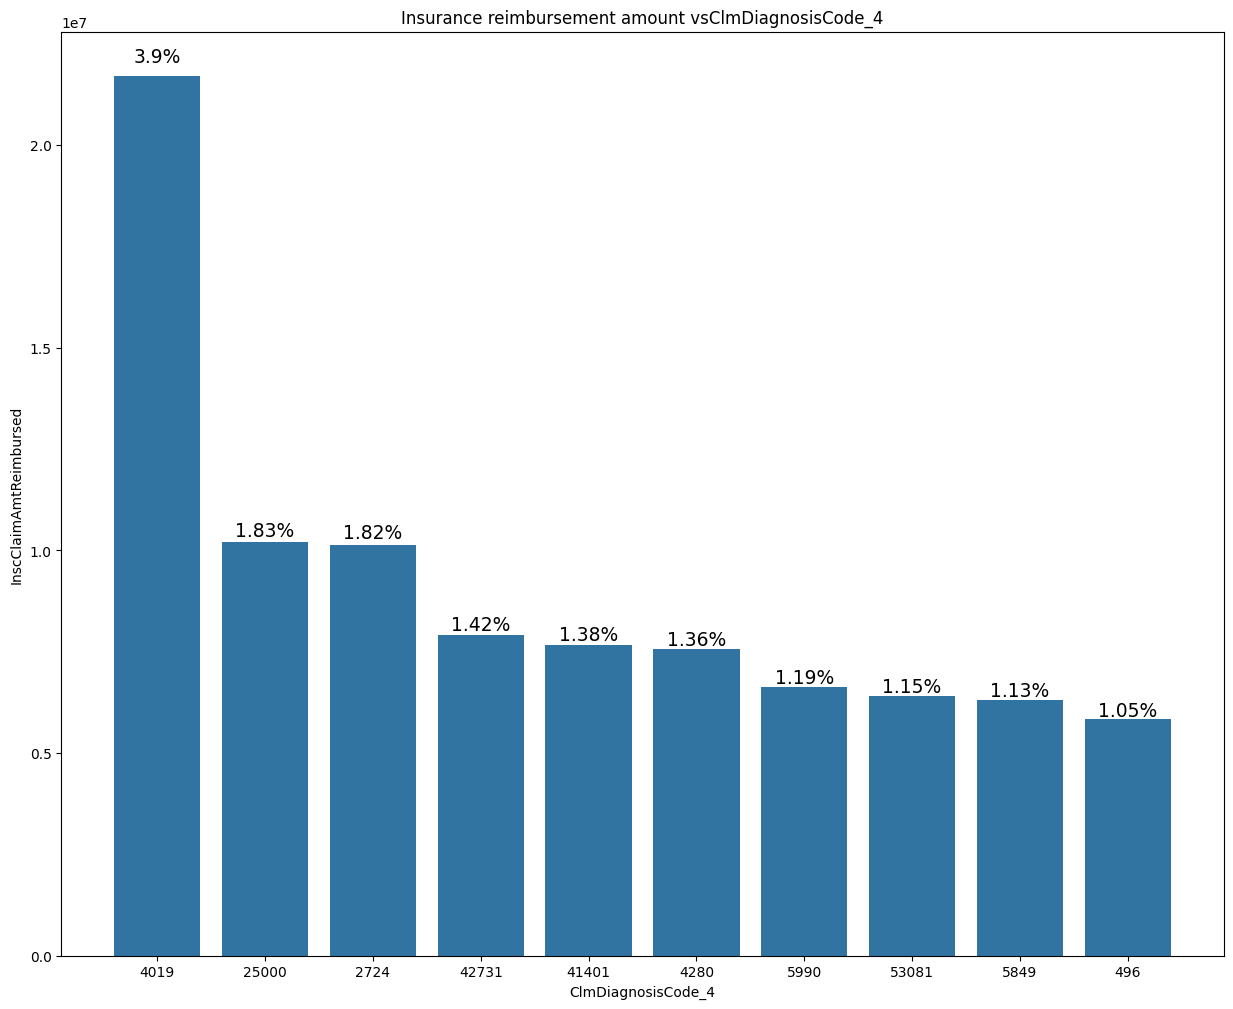

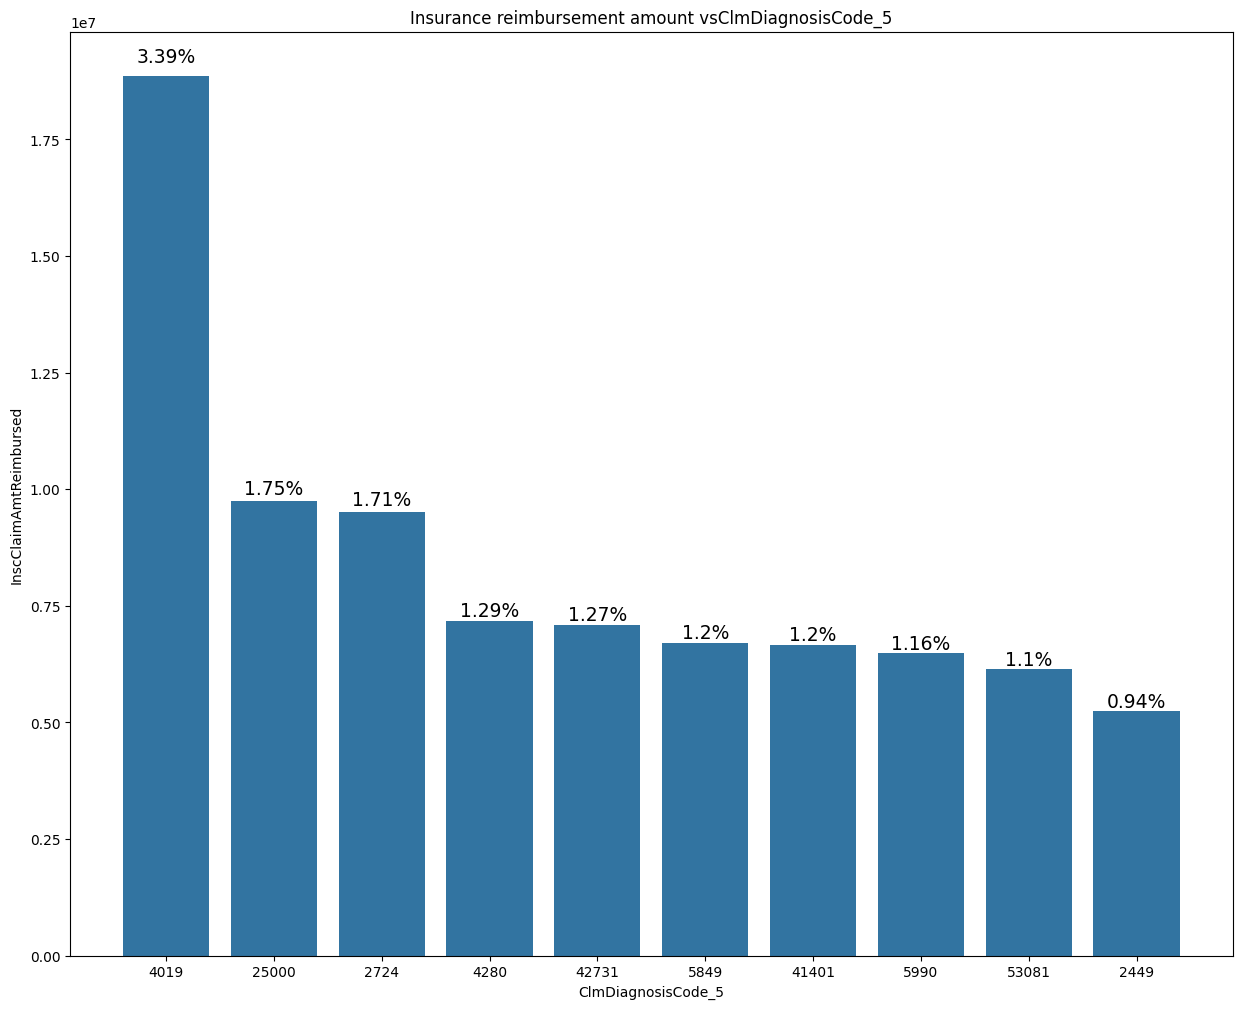

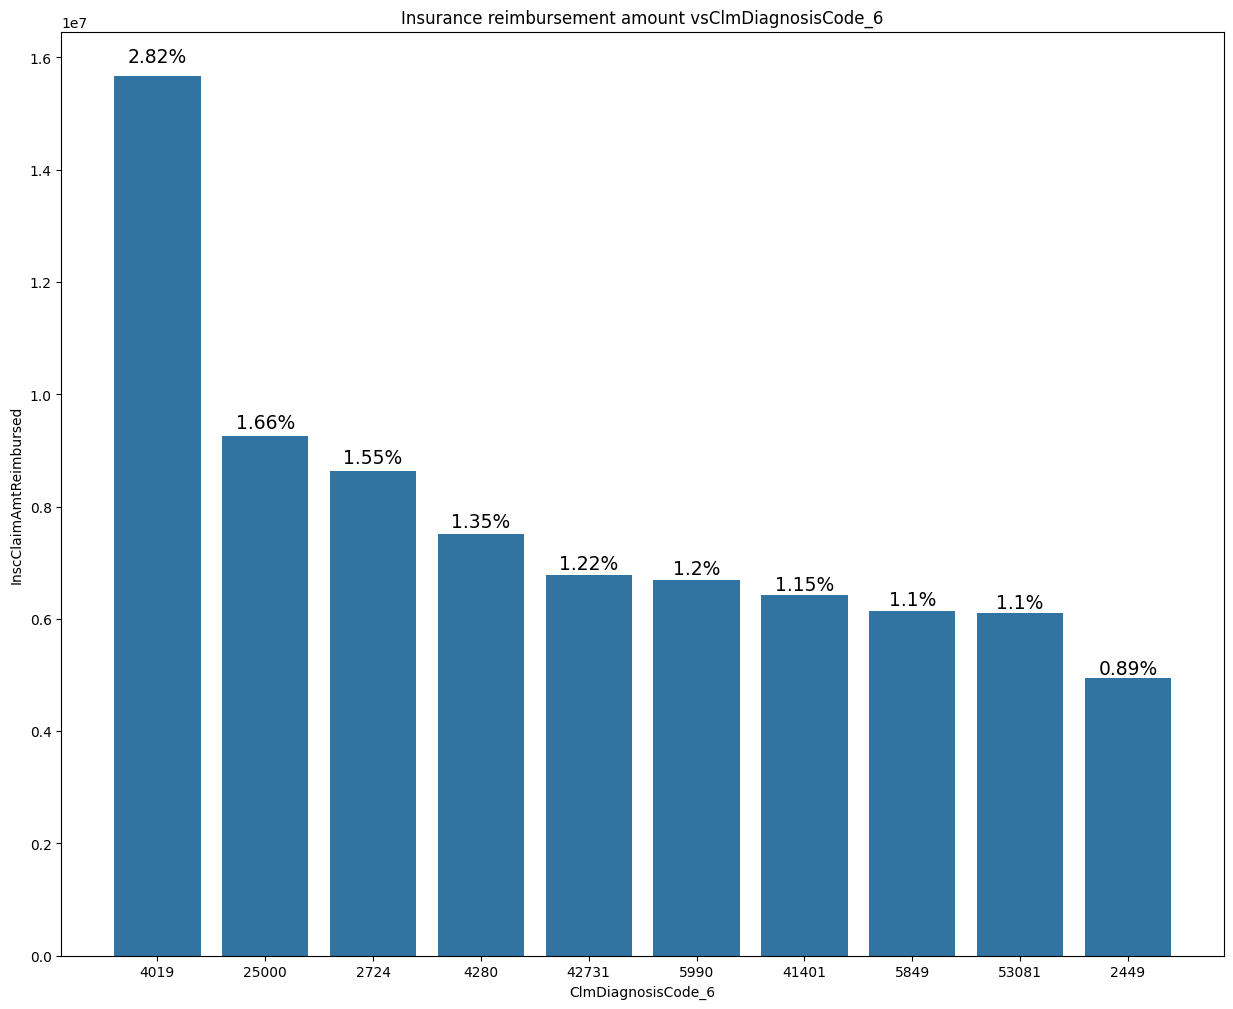

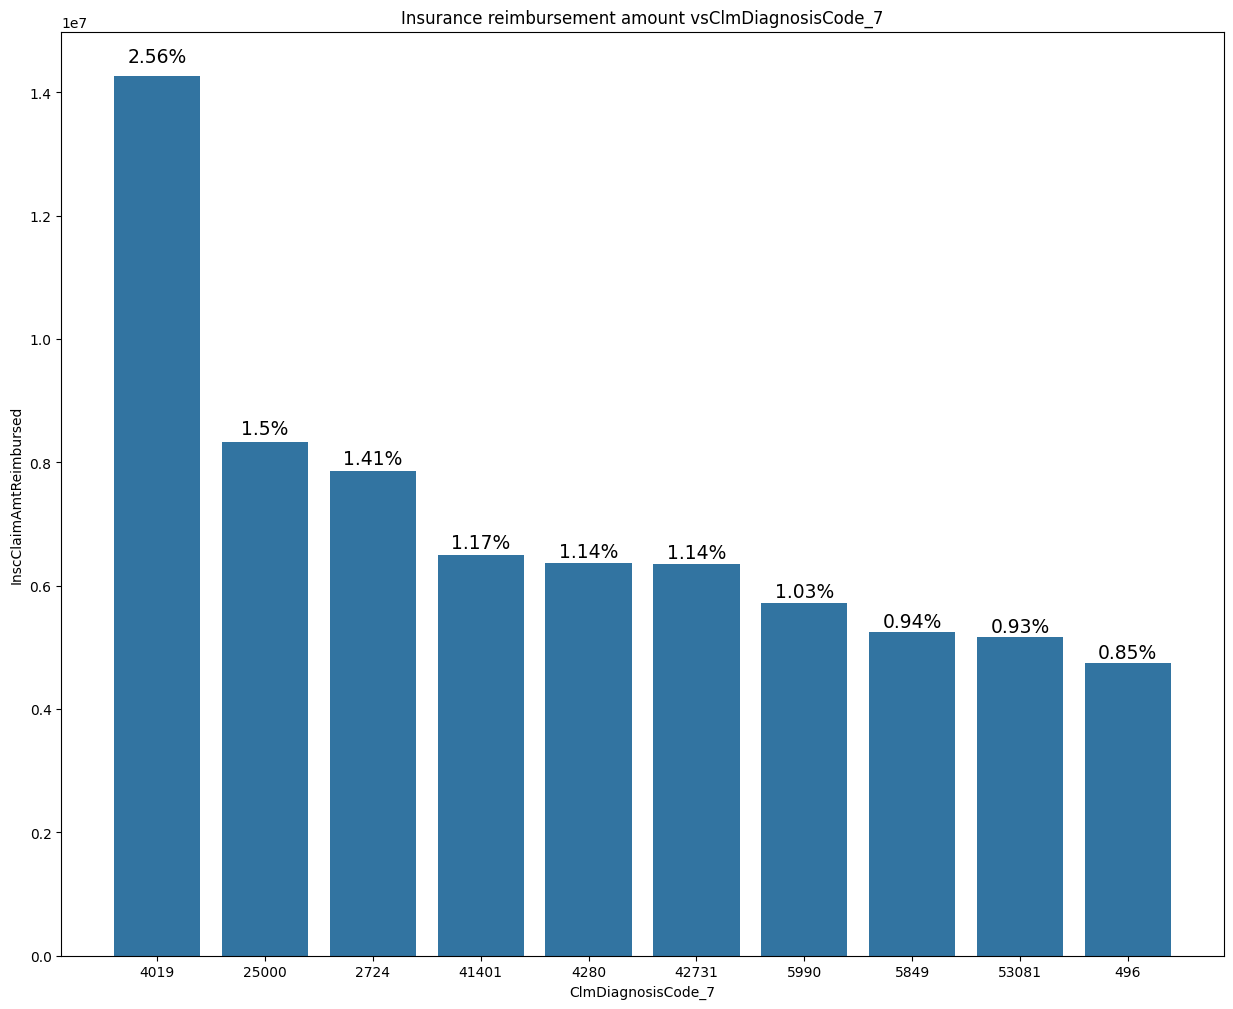

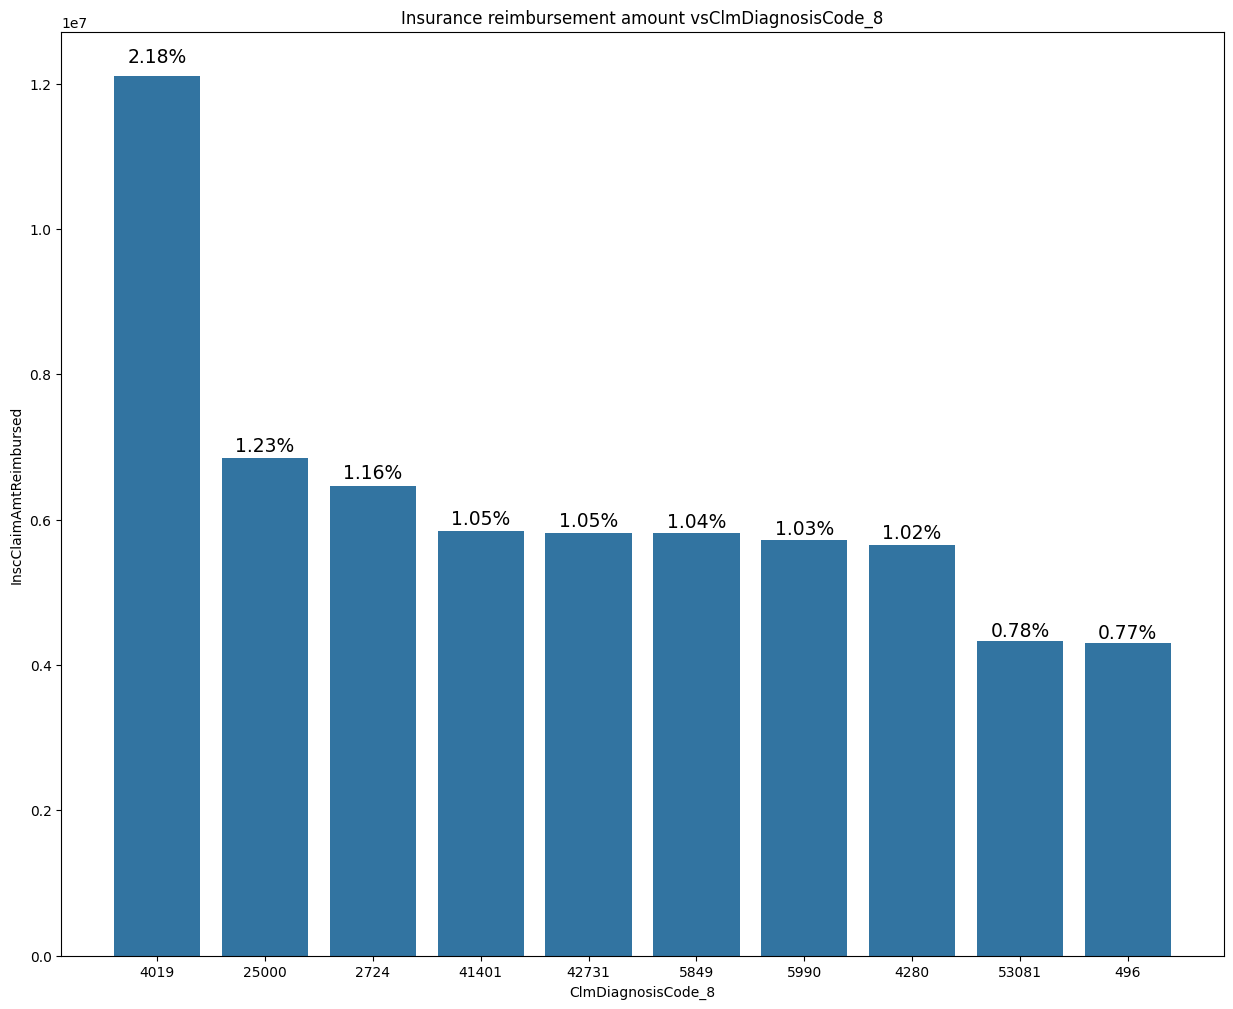

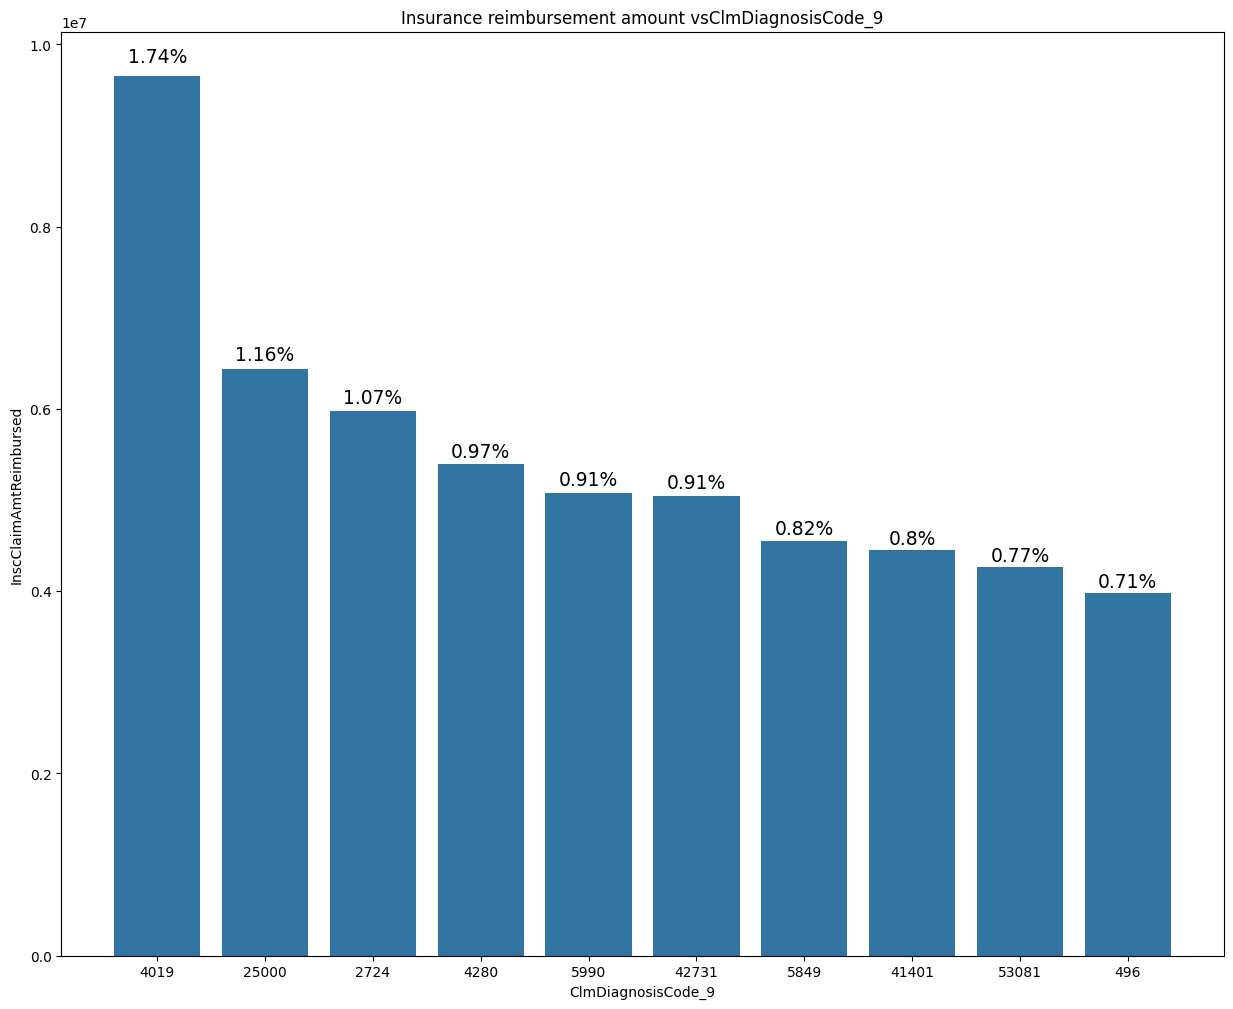

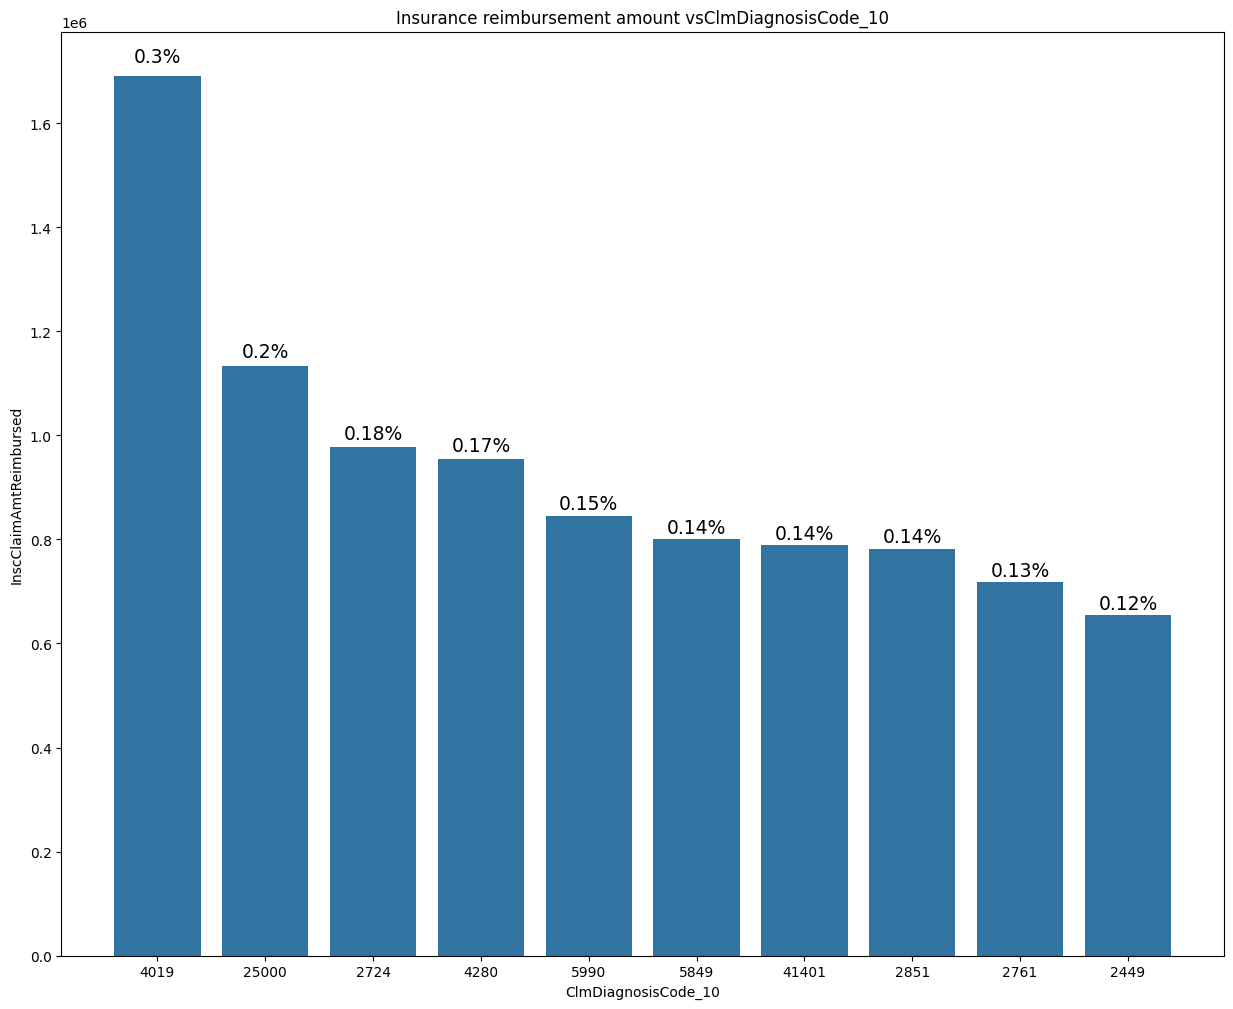

In [22]:
for i in ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
          'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
          'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
          'ClmDiagnosisCode_10']:
    df_sum=df_inp_outp_ben.groupby([i])['InscClaimAmtReimbursed'].sum()
    df_sum_1=df_sum.reset_index()
    df_sum_1.set_index(i)
    df_sorted=df_sum_1.sort_values(by=['InscClaimAmtReimbursed'],ascending=False).head(10)
    plt.figure(figsize=(15,12))
    fig=sns.barplot(data=df_sorted,x=i,y='InscClaimAmtReimbursed')
    for p in fig.patches:
      height=p.get_height()
      width=p.get_width()
      x,y=p.get_xy()
      fig.annotate(f'{str(round((height*100)/sum(df_inp_outp_ben['InscClaimAmtReimbursed']),2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
    plt.title("Insurance reimbursement amount vs"+i)
    plt.plot()
    

4019 code contribute to the highest reimbursement amount for all diagnosis code except for the first one. 

Q4. Most used diagnosis code group. Verify the variability of reimbursed amount?


In [23]:
data=df_inp_outp_ben['DiagnosisGroupCode'].value_counts().reset_index()

In [24]:
data_sorted=data.sort_values('count',ascending=False).head(10)

In [25]:
data_sorted

,DiagnosisGroupCode,count
0,882,179
1,884,174
2,166,168
3,183,165
4,939,163
6,883,160
5,168,160
7,887,159
8,204,158
10,876,156


[]

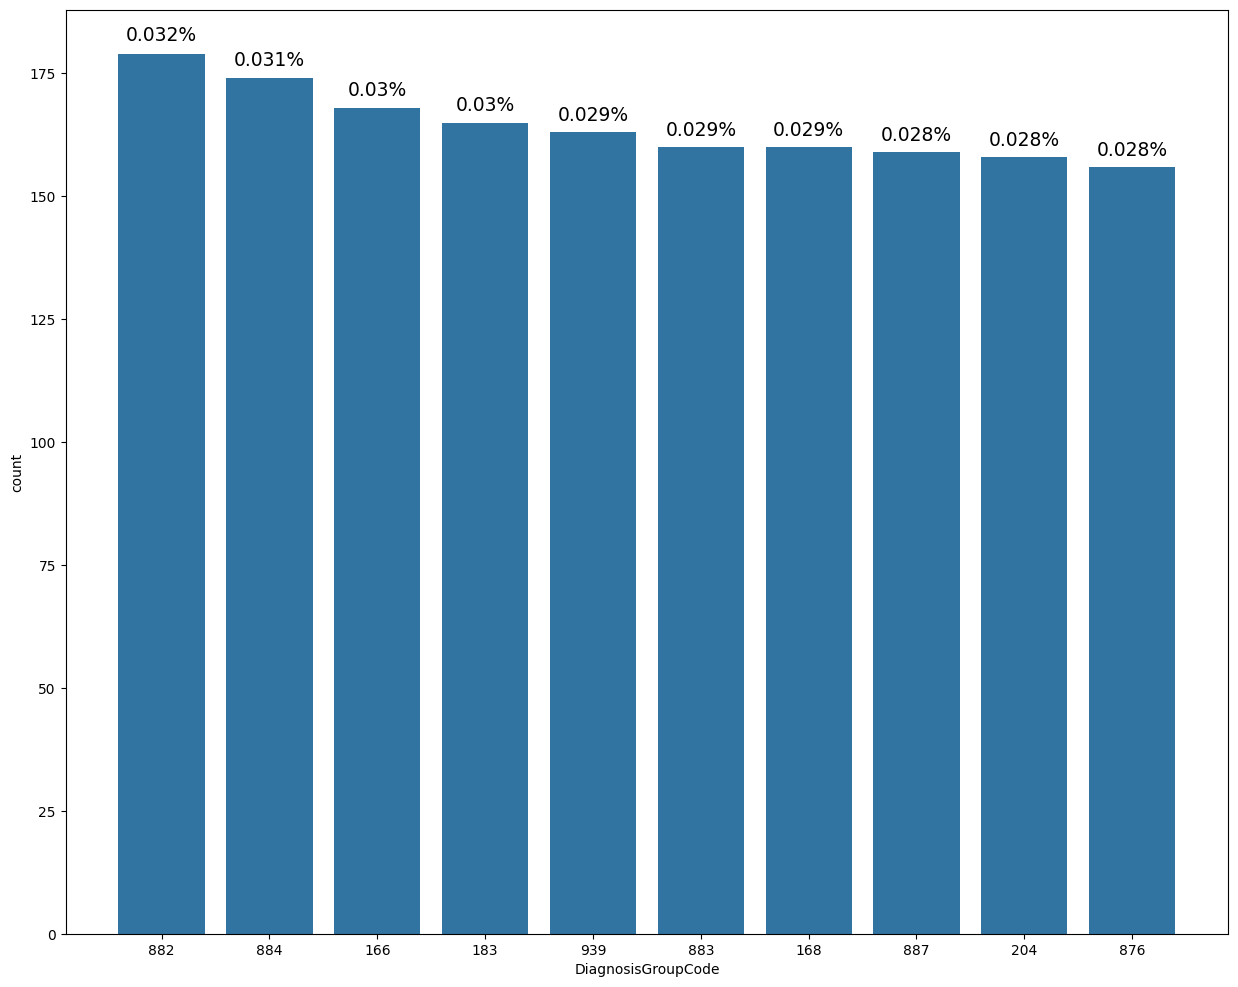

In [26]:
plt.figure(figsize=(15,12))
fig=sns.barplot(data=data_sorted,x='DiagnosisGroupCode',y='count')
for p in fig.patches:
      height=p.get_height()
      width=p.get_width()
      x,y=p.get_xy()
      fig.annotate(f'{str(round((height*100)/len(df_inp_outp_ben),3))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)

plt.plot()
    

Variability on reimbursement amount

In [122]:
data_var=df_inp_outp_ben.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].sum().reset_index()

In [123]:
data_top_10=data_var.sort_values(by='InscClaimAmtReimbursed',ascending=False).head(10)

[]

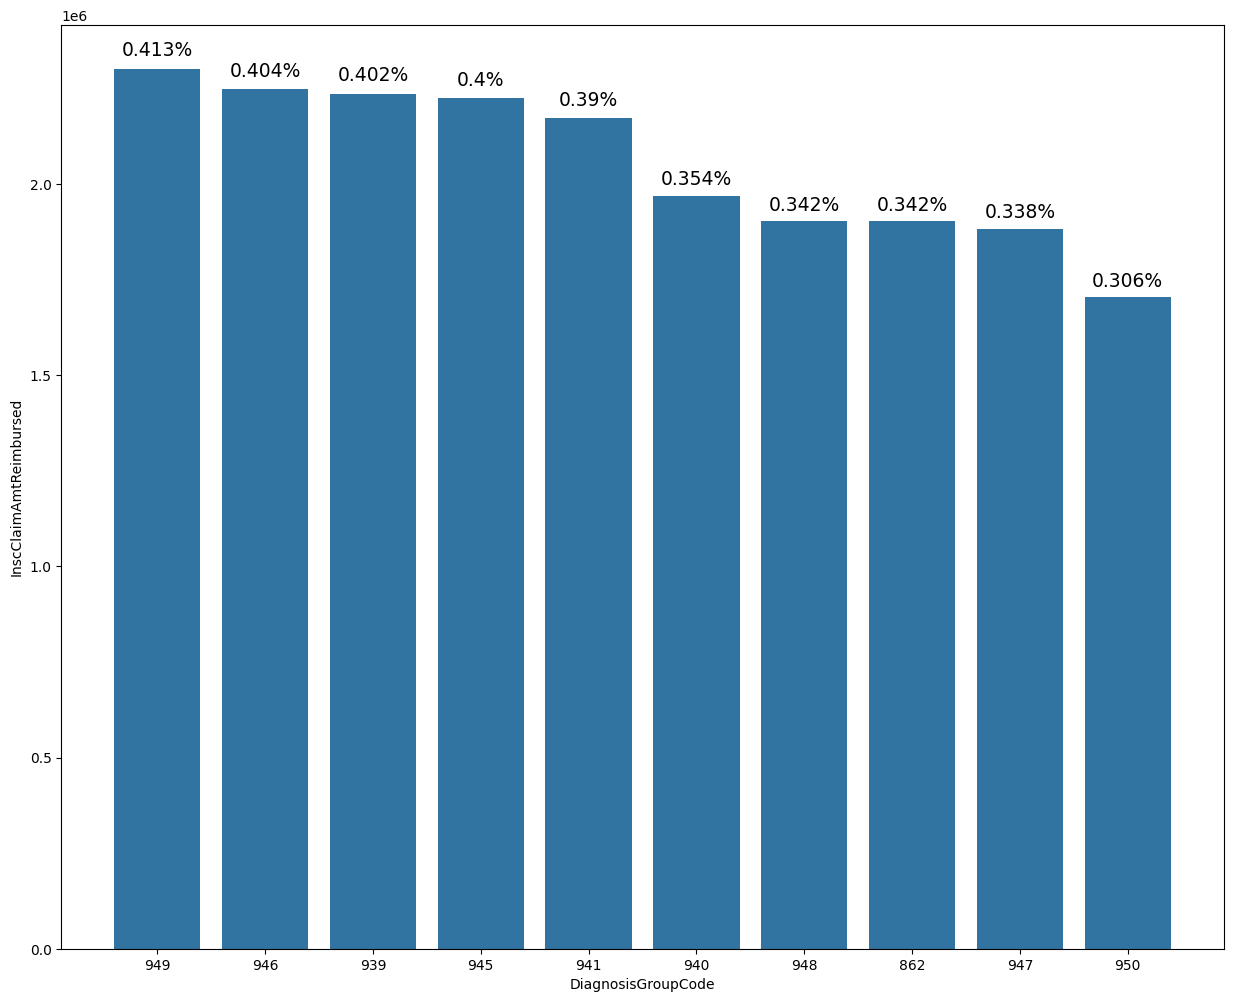

In [29]:
plt.figure(figsize=(15,12))
fig=sns.barplot(data=data_top_10,x='DiagnosisGroupCode',y='InscClaimAmtReimbursed')
for p in fig.patches:
      height=p.get_height()
      width=p.get_width()
      x,y=p.get_xy()
      fig.annotate(f'{str(round((height*100)/sum(df_inp_outp_ben['InscClaimAmtReimbursed']),3))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)

plt.plot()

Codes 939-951 has higher reimbursement amounts- This falls under "Factors Influencing Health Status & Other Contacts with Health Services". There is also 862- POSTOPERATIVE AND POST-TRAUMATIC INFECTIONS WITH MCC as one of the top 10 reimbursed drg codes in the dataset.

Q6. What are the conditions under the most used group code?

In [124]:
df_data_filtered = df_inp_outp_ben[df_inp_outp_ben['DiagnosisGroupCode'].isin(data_top_10['DiagnosisGroupCode'])]

In [31]:
df_clm_diag_cd = []  # Initialize an empty list

for i in ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
          'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
          'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
          'ClmDiagnosisCode_10']:
    
    df_clm_diag_cd.append(df_data_filtered[i].dropna())  # Append each column to the list
    df_combined_fil=pd.concat(df_clm_diag_cd,axis=0).reset_index(drop=True)
    df_combined_fil=pd.DataFrame(df_combined_fil,columns=['Diagnosiscode'])
    

In [32]:
df_combined_top10 = df_combined_fil.groupby('Diagnosiscode').size().reset_index(name='Count')
df_combined_top10 = df_combined_top10.sort_values(by='Count', ascending=False).head(10)

[]

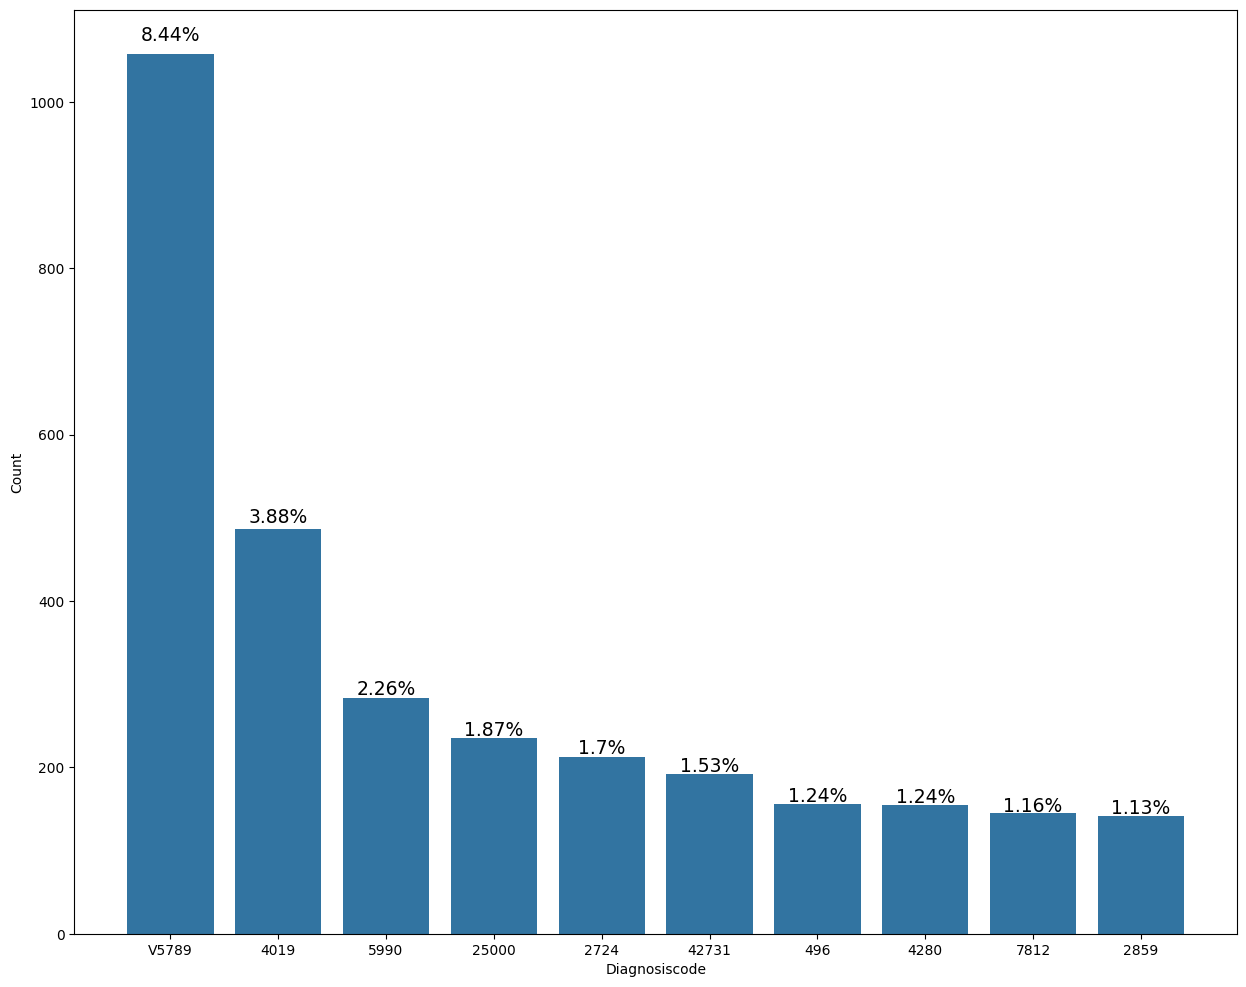

In [34]:
plt.figure(figsize=(15,12))
fig=sns.barplot(data=df_combined_top10,x='Diagnosiscode',y='Count')
for p in fig.patches:
    height=p.get_height()
    width=p.get_width()
    x,y=p.get_xy()
    fig.annotate(f'{str(round((height*100)/len(df_combined_fil),2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
plt.plot()


V6789- has been used the most.

Q6. What are the conditions under the most used group code?

In [40]:
for i in ['RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']:
    df_inp_outp_ben[i] = df_inp_outp_ben[i].apply(lambda val: 0 if val =='2' else 1)

In [42]:
df_data_filtered = df_inp_outp_ben[df_inp_outp_ben['DiagnosisGroupCode'].isin(data_top_10['DiagnosisGroupCode'])]

In [43]:
df_group_cond=df_data_filtered.groupby('DiagnosisGroupCode').sum()


In [45]:
df_group_cond[['RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']]

,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
DiagnosisGroupCode,,,,,,,,,,,,
862,122,68,96,93,23,68,63,106,104,45,42,22
939,163,84,121,103,31,67,69,137,138,62,64,31
940,147,72,103,93,25,71,62,125,123,59,47,39
941,145,64,94,83,23,69,74,118,122,57,55,40
945,156,72,103,79,30,62,66,119,134,54,53,36
946,144,66,93,76,25,60,68,118,120,47,63,39
947,141,62,89,65,23,58,71,114,116,61,50,31
948,142,68,101,82,26,58,55,116,121,54,54,26
949,154,80,111,84,18,71,78,120,131,64,68,40


Chronic diabetes, renal disease indicator and heart disease are conditions most seen.

Trend on phycisians with number of claims.

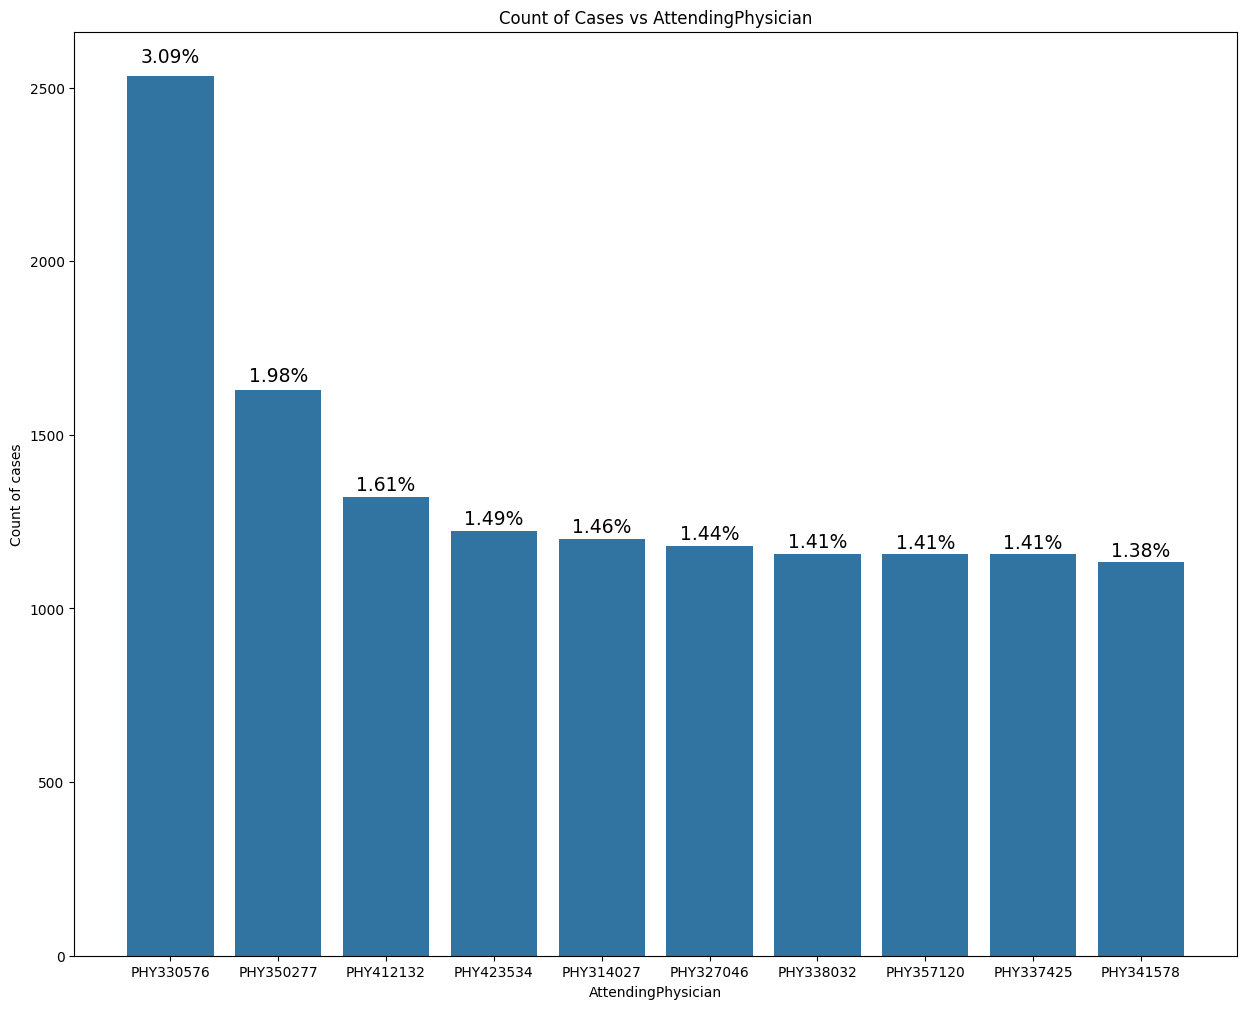

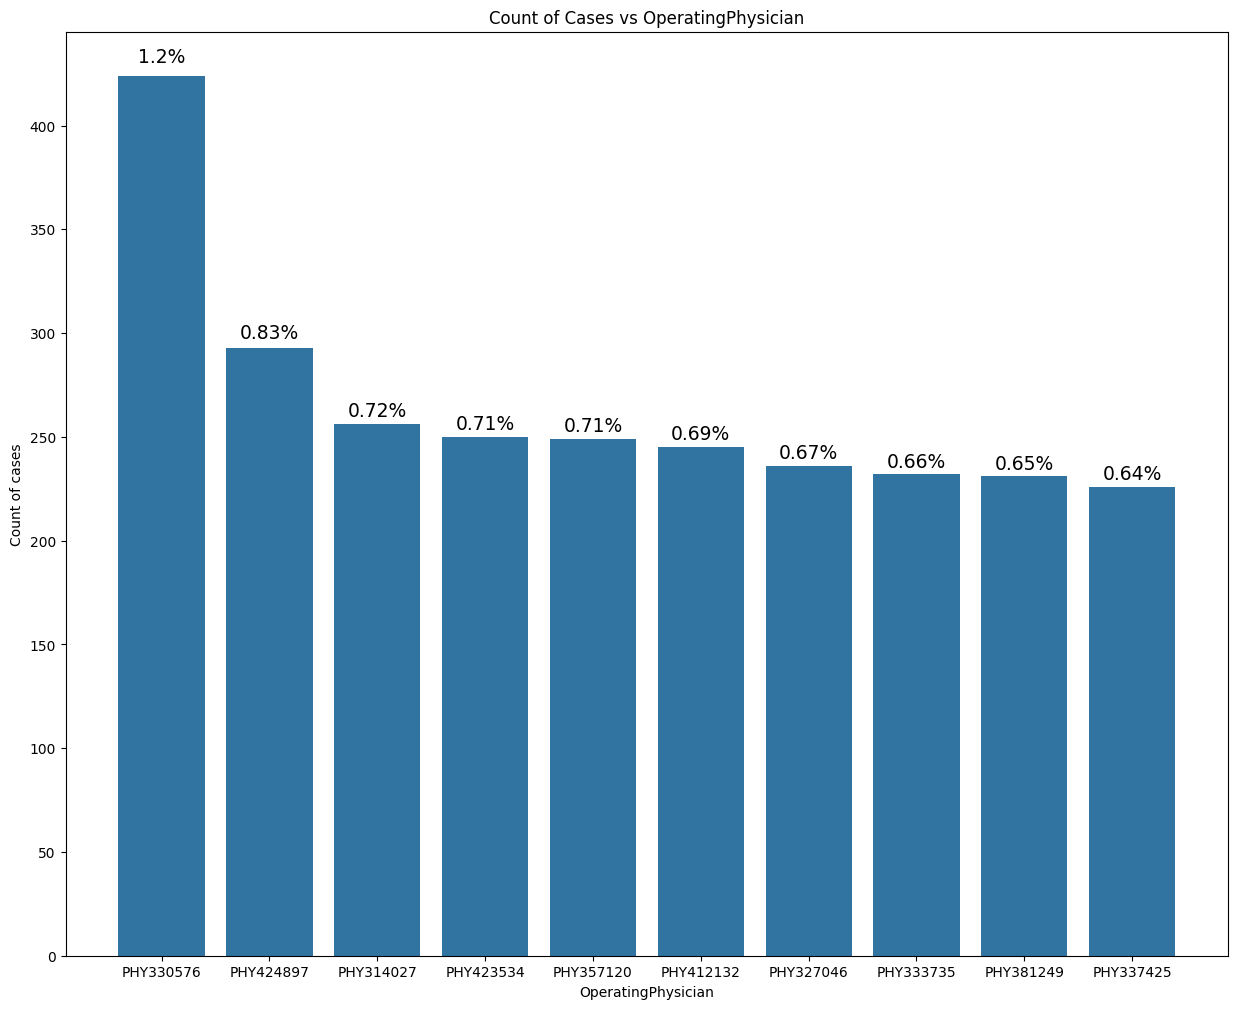

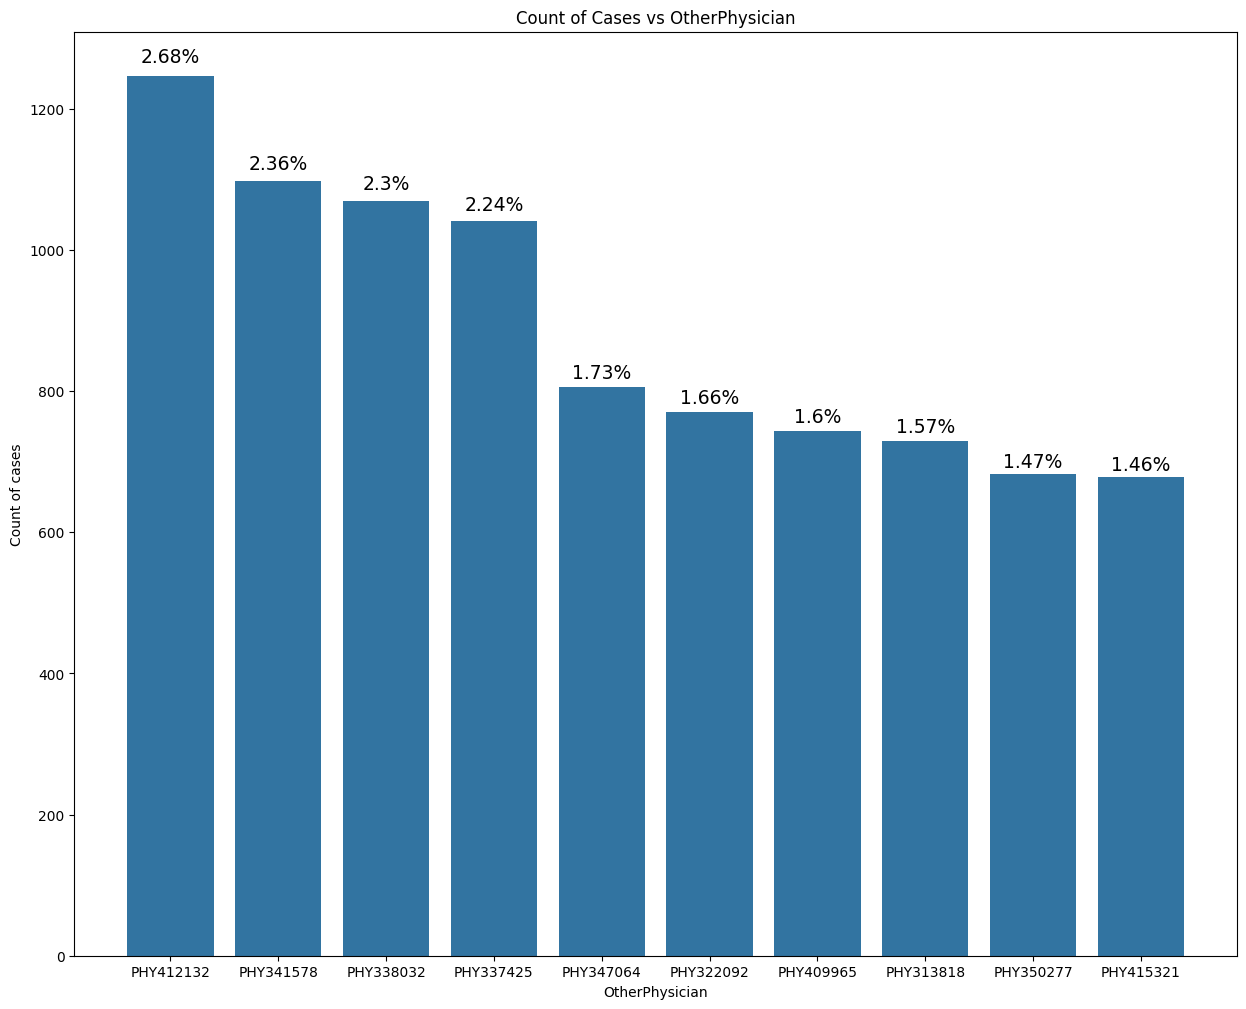

In [80]:
for i in ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']:
    df_phy_grp=df_inp_outp_ben.groupby(i)['BeneID'].count().reset_index()
    df_phy_grp_sorted=df_phy_grp.sort_values(by="BeneID",ascending=False).head(10)

    plt.figure(figsize=(15,12))
    fig=sns.barplot(data=df_phy_grp_sorted,x=i,y='BeneID')
    for p in fig.patches:
        height=p.get_height()
        width=p.get_width()
        x,y=p.get_xy()
        fig.annotate(f'{str(round((height*100)/len(df_phy_grp),2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
        plt.ylabel("Count of cases")
        plt.title("Count of Cases vs "+i )
    plt.plot()

Physicians with high insurance reimbursement

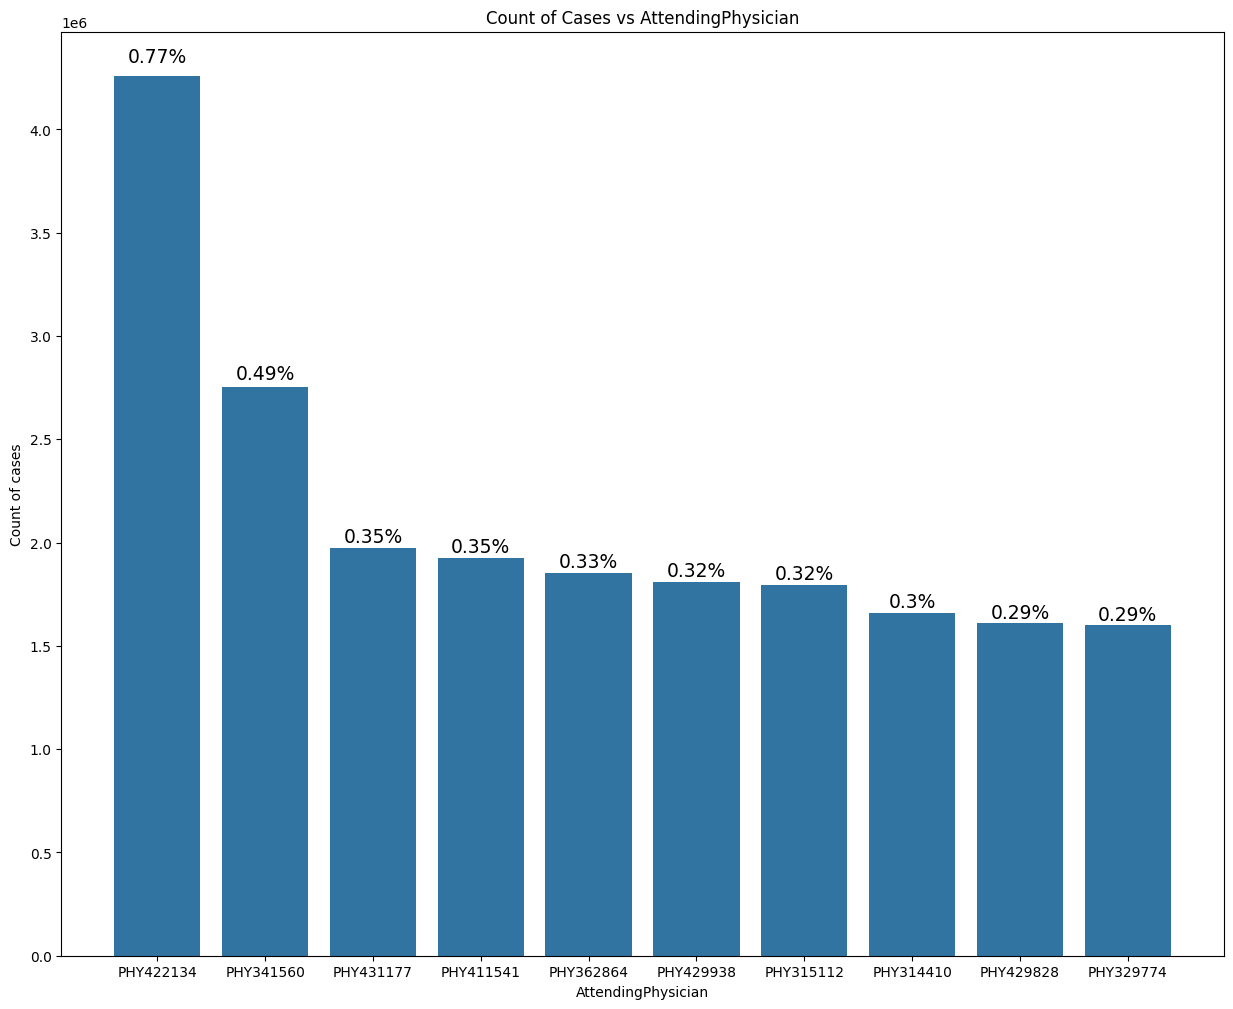

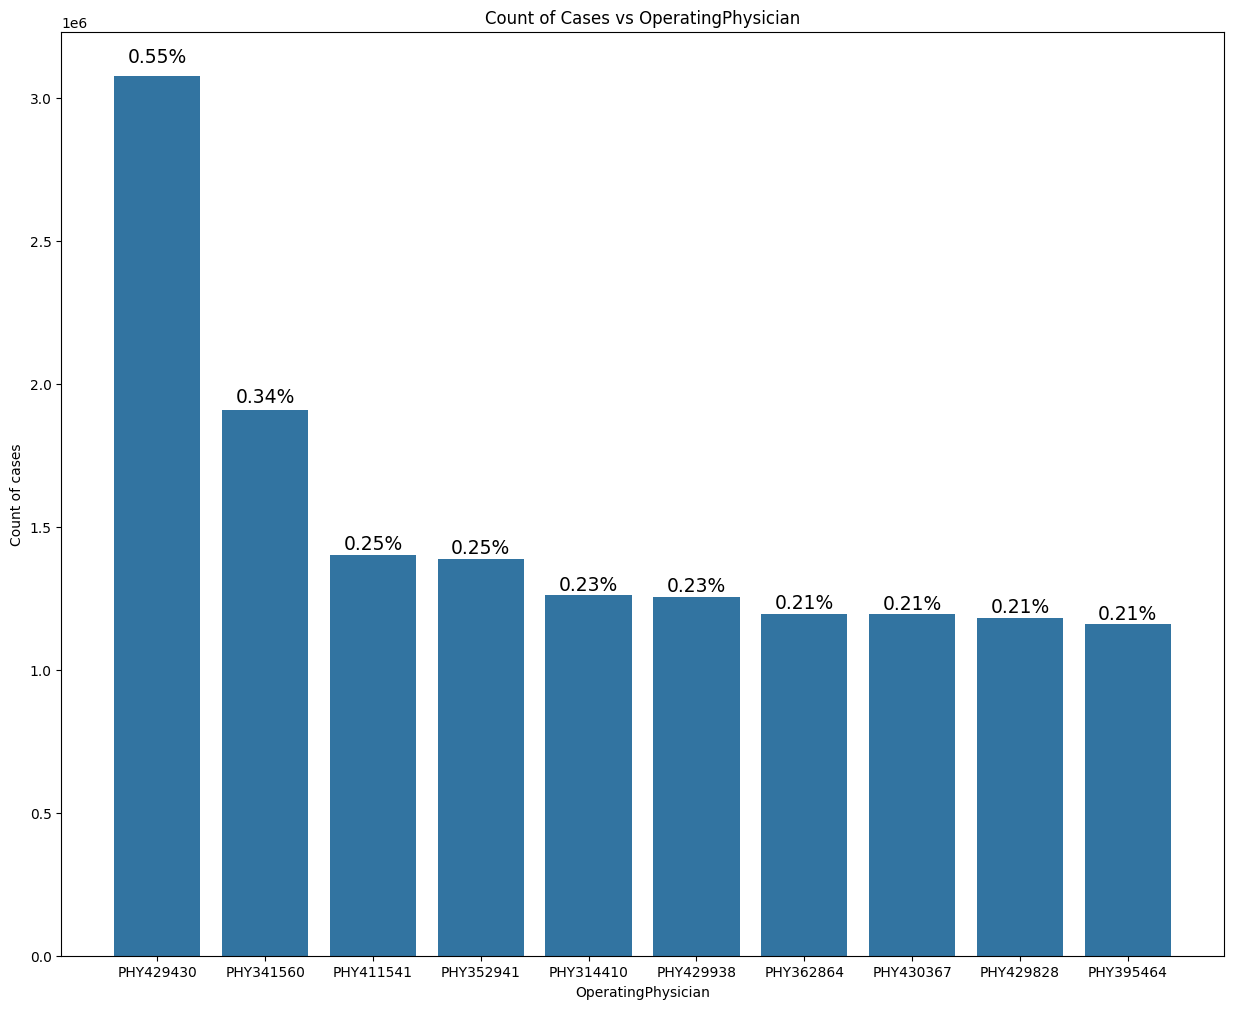

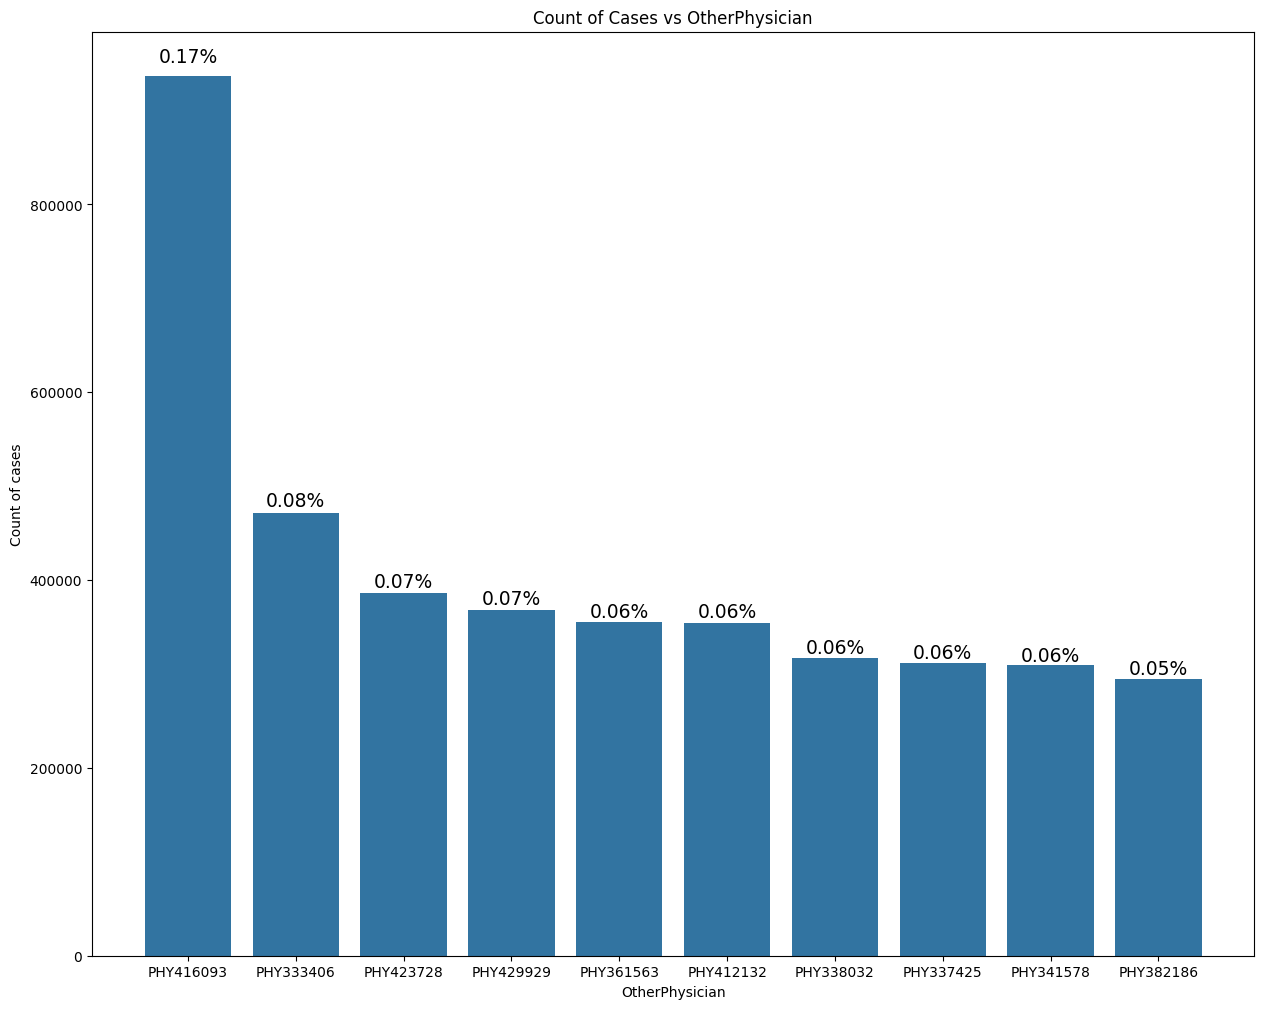

In [81]:
for i in ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']:
    df_phy_grp=df_inp_outp_ben.groupby(i)['InscClaimAmtReimbursed'].sum().reset_index()
    df_phy_grp_sorted=df_phy_grp.sort_values(by="InscClaimAmtReimbursed",ascending=False).head(10)

    plt.figure(figsize=(15,12))
    fig=sns.barplot(data=df_phy_grp_sorted,x=i,y='InscClaimAmtReimbursed')
    for p in fig.patches:
        height=p.get_height()
        width=p.get_width()
        x,y=p.get_xy()
        fig.annotate(f'{str(round((height*100)/(df_inp_outp_ben['InscClaimAmtReimbursed'].sum()),2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
        plt.ylabel("Count of cases")
        plt.title("Count of Cases vs "+i )
    plt.plot()

Q8. Variation of DRG with insurance reimbursement amount

In [118]:
df_inp_outp_ben.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'Claim_period', 'Beneficiary_cost', 'Count_diag_code',
       'Count_proc_code', 'Admit_Period', 'Is_admit', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'Chro

In [121]:
df_inp_outp_ben['DiagnosisGroupCode'].value_counts()

DiagnosisGroupCode
882    179
884    174
166    168
183    165
939    163
      ... 
765      1
927      1
955      1
934      1
768      1
Name: count, Length: 736, dtype: int64

<Axes: xlabel='DiagnosisGroupCode', ylabel='InscClaimAmtReimbursed'>

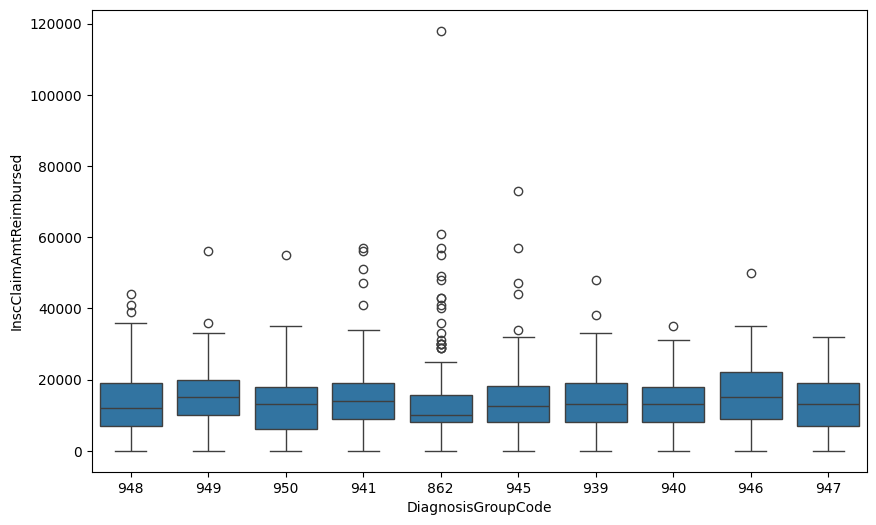

In [130]:
df_top_10=df_inp_outp_ben.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].sum().reset_index()
df_top_10_sorted=df_top_10.sort_values(by='InscClaimAmtReimbursed',ascending=False).head(10)
df_data_filtered=df_inp_outp_ben[df_inp_outp_ben['DiagnosisGroupCode'].isin(df_top_10_sorted['DiagnosisGroupCode'])]
plt.figure(figsize=(10, 6))
sns.boxplot(x='DiagnosisGroupCode', y='InscClaimAmtReimbursed', data=df_data_filtered)

There are variations and outliers in distribution of insurance claim reimbursement amount across top 10 DRG codes among providers. These ouliers could be potential fraudulent transactions.

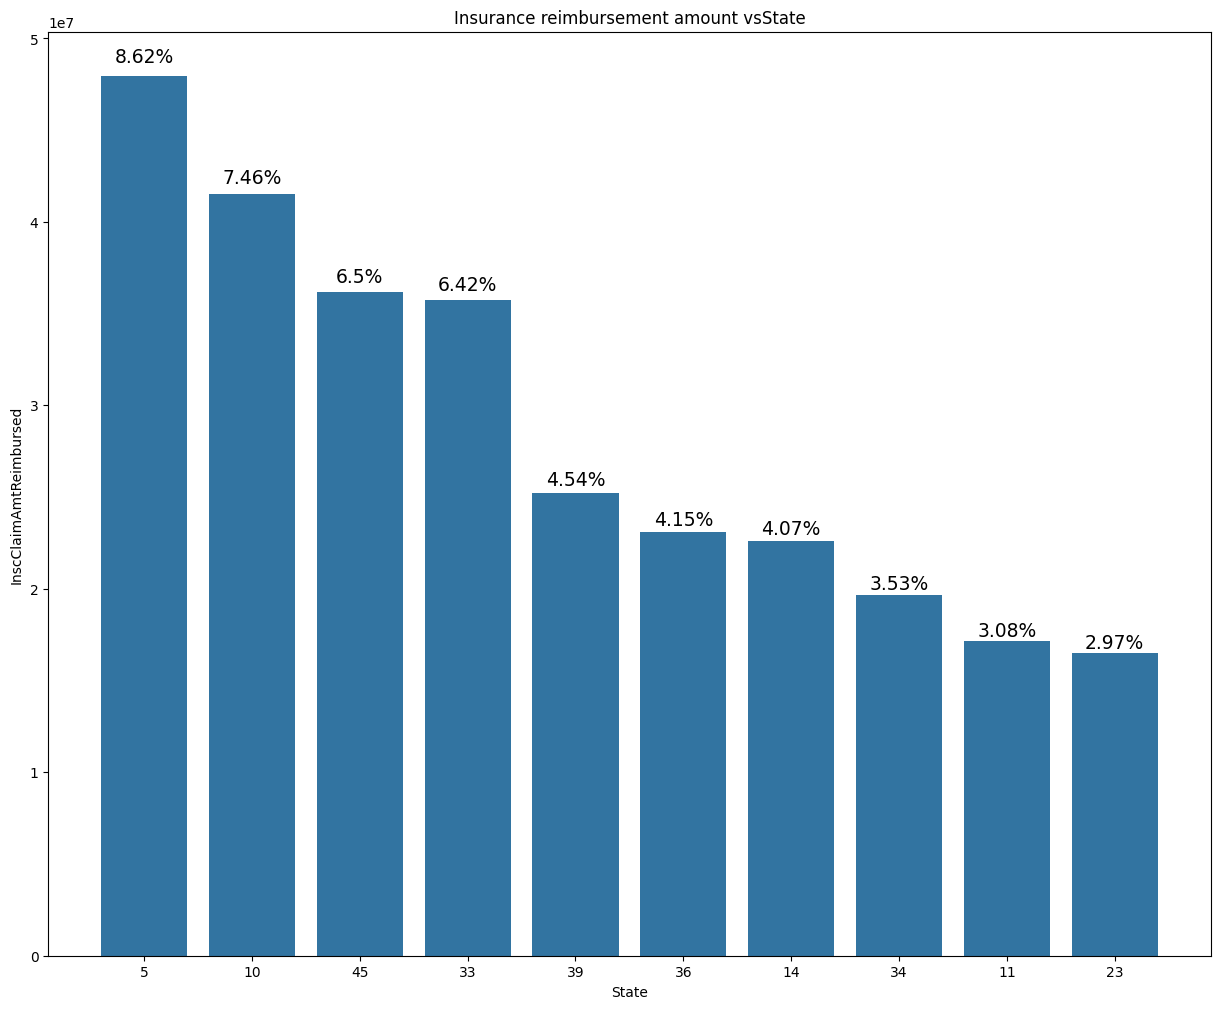

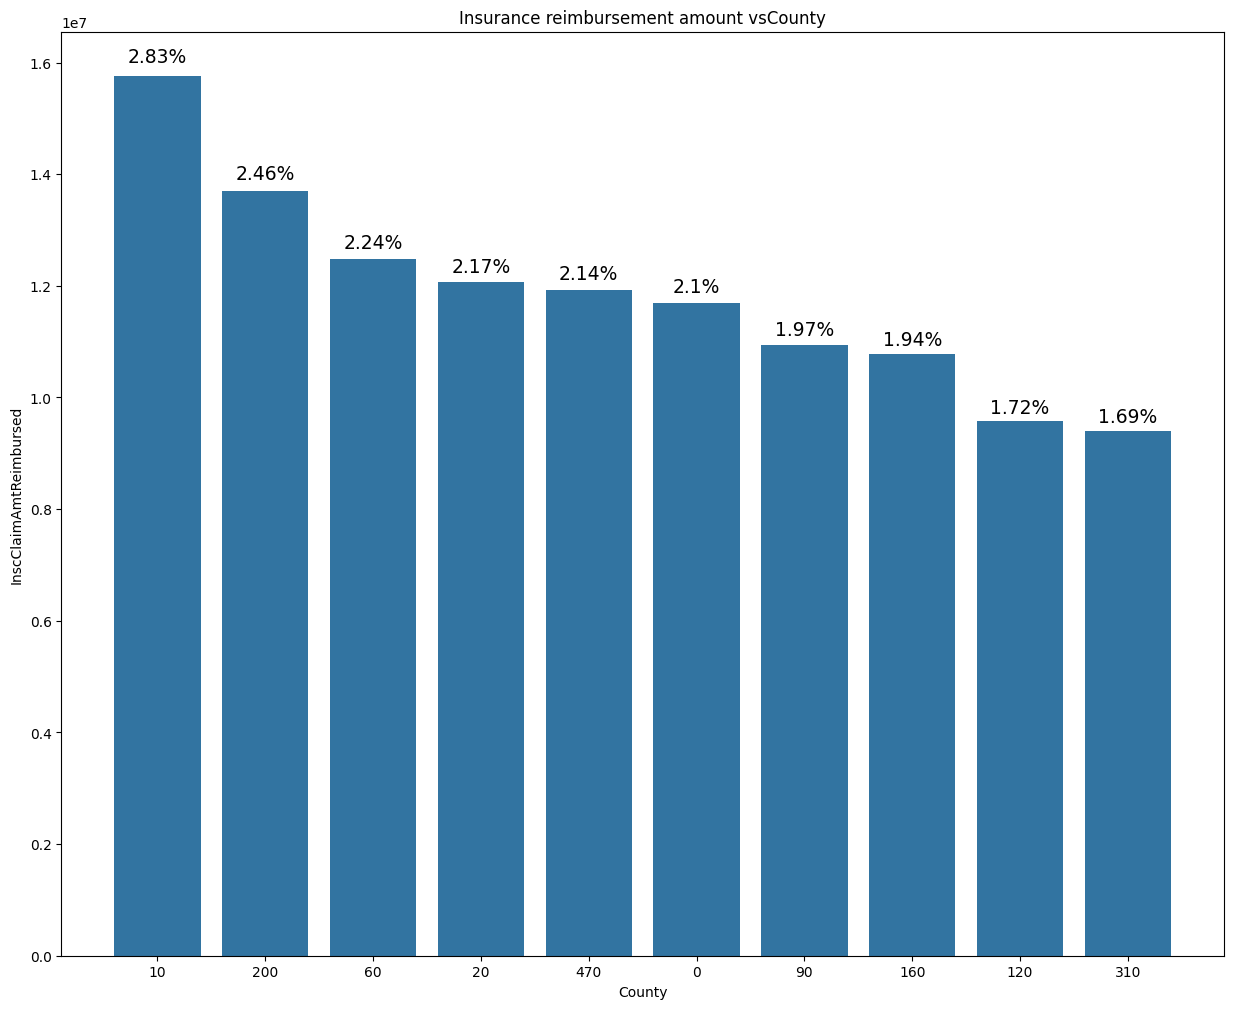

In [34]:
for i in ['State','County']:
    df_sum=df_inp_outp_ben.groupby([i])['InscClaimAmtReimbursed'].sum()
    df_sum_1=df_sum.reset_index()
    df_sum_1.set_index(i)
    df_sorted=df_sum_1.sort_values(by=['InscClaimAmtReimbursed'],ascending=False).head(10)
    plt.figure(figsize=(15,12))
    fig=sns.barplot(data=df_sorted,x=i,y='InscClaimAmtReimbursed')
    for p in fig.patches:
      height=p.get_height()
      width=p.get_width()
      x,y=p.get_xy()
      fig.annotate(f'{str(round((height*100)/sum(df_inp_outp_ben['InscClaimAmtReimbursed']),2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
    plt.title("Insurance reimbursement amount vs"+i)
    plt.plot()

<Axes: xlabel='State', ylabel='InscClaimAmtReimbursed'>

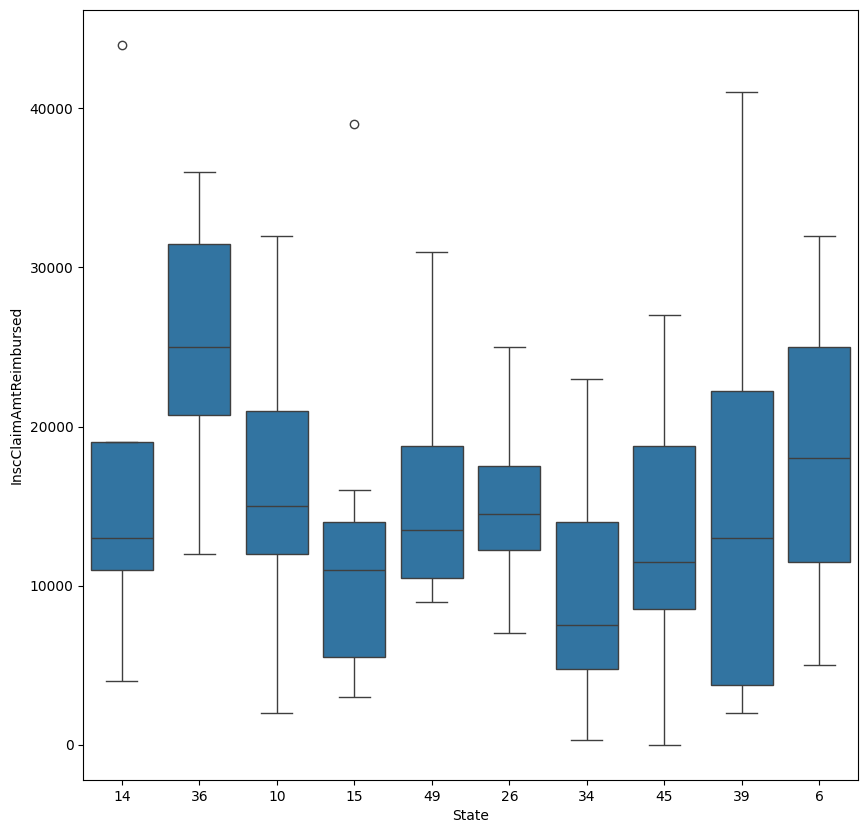

In [46]:
df_filter_drg=df_inp_outp_ben[df_inp_outp_ben.DiagnosisGroupCode=='948']
df_top_10=df_filter_drg.groupby('State')['InscClaimAmtReimbursed'].sum().reset_index()
df_top_10_sorted=df_top_10.sort_values(by='InscClaimAmtReimbursed',ascending=False).head(10)
df_data_filtered=df_filter_drg[df_filter_drg['State'].isin(df_top_10_sorted['State'])]
plt.figure(figsize=(10, 10))
sns.boxplot(x='State', y='InscClaimAmtReimbursed', data=df_data_filtered)
# plt.ylim(0,1000)

**There is a high variability in the claim reimbursed amount in different states for same DRG code.**

Q11. Number of ICD codes based on insurance reimbursed amount

<Axes: xlabel='Count_diag_code', ylabel='InscClaimAmtReimbursed'>

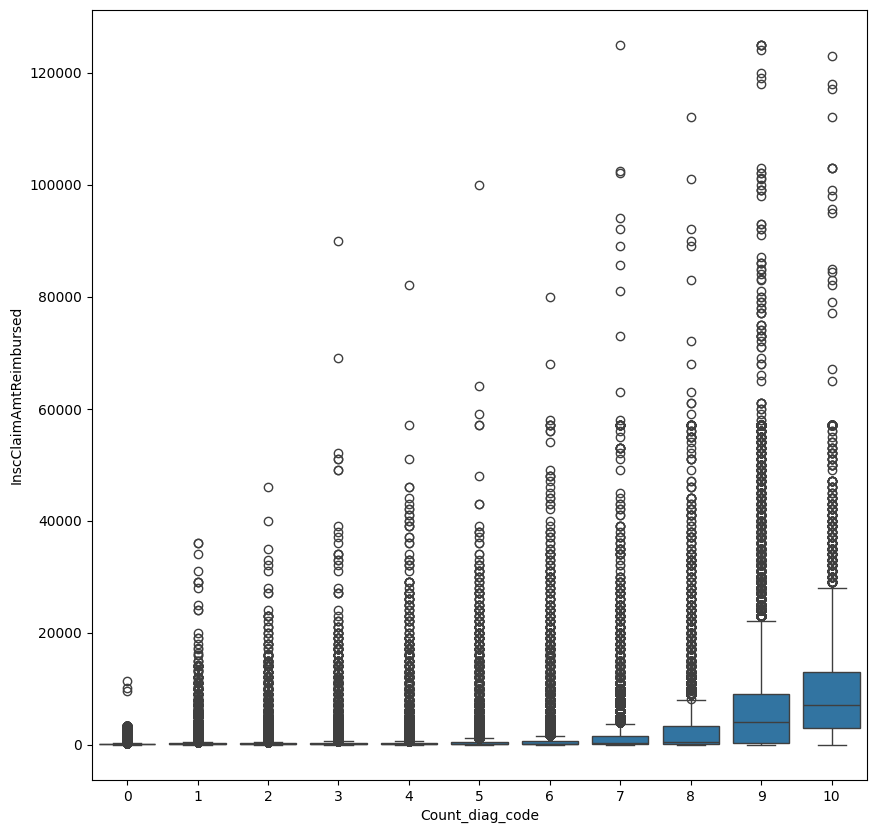

In [177]:

plt.figure(figsize=(10, 10))
sns.boxplot(x='Count_diag_code', y='InscClaimAmtReimbursed', data=df_inp_outp_ben)
# plt.ylim(0,1000)